# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import coo_matrix, csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import pickle
import random

# 1. Data Loading and Preprocessing


In [2]:
# Load dataset
df_songs = pd.read_csv('../datasets/songs.csv', chunksize=50000)
df_songs_list = [chunk.fillna('') for chunk in df_songs]
df_songs = pd.concat(df_songs_list).reset_index(drop=True)

# Normalize listen counts
scaler = MinMaxScaler()
df_songs['listen_count'] = scaler.fit_transform(df_songs[['listen_count']])

# Encode user_id and song_id
df_songs['user_id_code'] = df_songs['user_id'].astype('category').cat.codes
df_songs['song_id_code'] = df_songs['song_id'].astype('category').cat.codes

# Prepare user-song matrix
user_song_matrix = coo_matrix(
    (df_songs['listen_count'], (df_songs['user_id_code'], df_songs['song_id_code'])),
    shape=(df_songs['user_id_code'].nunique(), df_songs['song_id_code'].nunique())
)

# 2. Exploratory Data Analysis (EDA)

Dataset shape: (99999, 9)
Missing values:
user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
user_id_code    0
song_id_code    0
dtype: int64


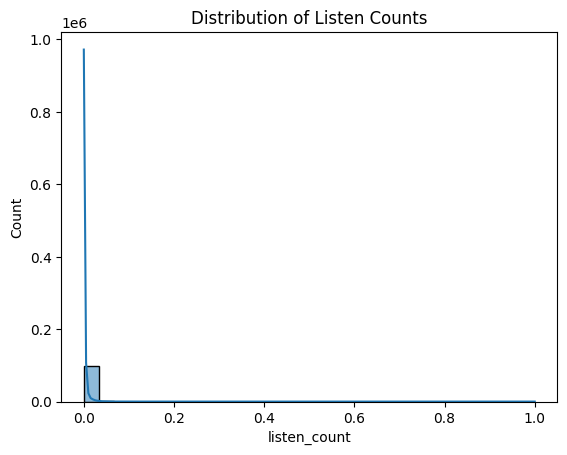

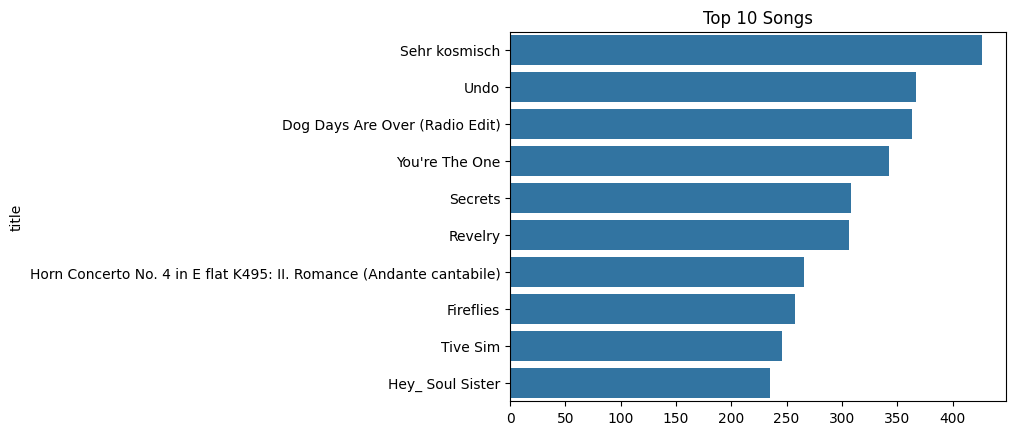

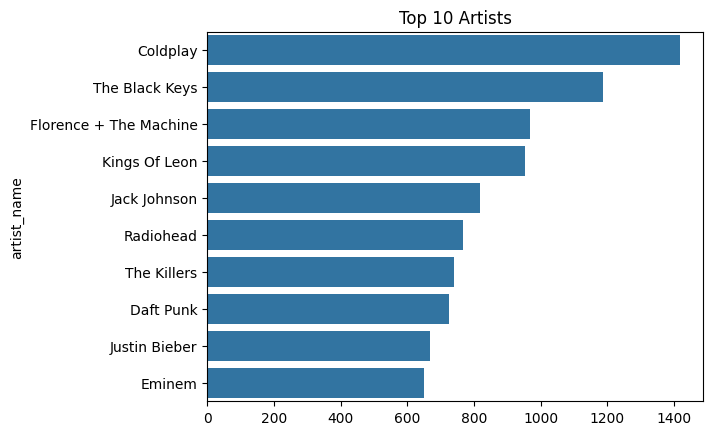

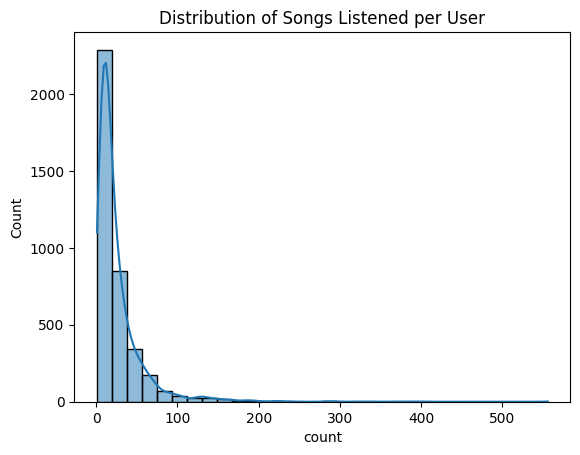

In [3]:
# Overview of the dataset
print(f"Dataset shape: {df_songs.shape}")
print(f"Missing values:\n{df_songs.isnull().sum()}")

# Distribution of listen counts
sns.histplot(df_songs['listen_count'], bins=30, kde=True)
plt.title('Distribution of Listen Counts')
plt.show()

# Top 10 Songs
top_songs = df_songs['title'].value_counts().head(10)
sns.barplot(x=top_songs.values, y=top_songs.index)
plt.title('Top 10 Songs')
plt.show()

# Top 10 Artists
top_artists = df_songs['artist_name'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title('Top 10 Artists')
plt.show()

# User activity (number of songs listened to per user)
user_activity = df_songs['user_id'].value_counts()
sns.histplot(user_activity, bins=30, kde=True)
plt.title('Distribution of Songs Listened per User')
plt.show()


# 3. Model Selection 

In [4]:
# Initialize and fit the k-NN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_song_matrix)

# Save the model
model_filename = 'best_knn_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model_knn, file)

# 4. Model Evaluation and Saving

In [6]:
from sklearn.metrics import precision_score, recall_score
from scipy.sparse import coo_matrix

def evaluate_model_incremental(model, test_data, user_song_matrix, n_neighbors=5, batch_size=1000):
    # Create mappings
    song_id_to_index = df_songs[['song_id', 'song_id_code']].drop_duplicates().set_index('song_id')['song_id_code'].to_dict()
    user_id_to_index = test_data[['user_id', 'user_id_code']].drop_duplicates().set_index('user_id')['user_id_code'].to_dict()
    
    precision_total = []
    recall_total = []
    num_batches = int(np.ceil(len(test_data) / batch_size))

    for batch in range(num_batches):
        batch_data = test_data.iloc[batch * batch_size : (batch + 1) * batch_size]
        
        for user_id, user_data in batch_data.groupby('user_id'):
            user_index = user_id_to_index.get(user_id)
            if user_index is None:
                continue
            
            # Use sparse matrix directly
            user_vector = user_song_matrix.getrow(user_index).toarray()
            distances, indices = model.kneighbors(user_vector, n_neighbors=n_neighbors)
            
            true_liked_songs = set(user_data['song_id'])
            recommended_songs = set(df_songs.iloc[indices.flatten()]['song_id'])
            
            # Initialize y_true and y_pred with the correct size
            num_songs = len(song_id_to_index)
            y_true = np.zeros(num_songs, dtype=int)
            y_pred = np.zeros(num_songs, dtype=int)
            
            # Set true labels
            for song_id in true_liked_songs:
                if song_id in song_id_to_index:
                    y_true[song_id_to_index[song_id]] = 1
            
            # Set predicted labels
            for song_id in recommended_songs:
                if song_id in song_id_to_index:
                    y_pred[song_id_to_index[song_id]] = 1
            
            # Compute precision and recall
            if np.any(y_true) or np.any(y_pred):
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                precision_total.append(precision)
                recall_total.append(recall)
        
    # Average precision and recall across all batches
    average_precision = np.mean(precision_total) if precision_total else 0
    average_recall = np.mean(recall_total) if recall_total else 0
    
    return average_precision, average_recall

# # Test with a smaller subset to verify
# test_data_sample = test_data.sample(n=1000, random_state=42)
# precision, recall = evaluate_model_incremental(model_knn, test_data_sample, user_song_matrix)
# print(f"Sample Precision: {precision:.2f}, Sample Recall: {recall:.2f}")




# 5. Integration with Spotify API for Song Search and Recommendation

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set up Spotify API credentials
client_credentials_manager = SpotifyClientCredentials(client_id='380a6b3535dc420a905dccf328a0e165', client_secret='b0ca7947448246d28aafc40f49610cf4')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Function to search for a song on Spotify by its title and artist name
def search_song_on_spotify(query):
    try:
        results = sp.search(q=query, type='track', limit=1)
        if results['tracks']['items']:
            track = results['tracks']['items'][0]
            return {
                'title': track['name'],
                'artist': track['artists'][0]['name'],
                'spotify_id': track['id'],
                'preview_url': track['preview_url'],
                'external_url': track['external_urls']['spotify']
            }
        else:
            return None
    except Exception as e:
        print(f"Error searching for song: {e}")
        return None

# Example usage
song_query = "The Cove Jack Johnson"
search_result = search_song_on_spotify(song_query)
print(search_result)

# Function to recommend songs using Spotify API
def recommend_songs_from_spotify(seed_tracks, limit=5):
    try:
        recommendations = sp.recommendations(seed_tracks=seed_tracks, limit=limit)
        recommended_songs = []
        for track in recommendations['tracks']:
            recommended_songs.append({
                'title': track['name'],
                'artist': track['artists'][0]['name'],
                'spotify_id': track['id'],
                'preview_url': track['preview_url'],
                'external_url': track['external_urls']['spotify']
            })
        return recommended_songs
    except Exception as e:
        print(f"Error getting recommendations from Spotify: {e}")
        return None

# Example usage
seed_tracks = [search_result['spotify_id']]
spotify_recommendations = recommend_songs_from_spotify(seed_tracks)
for song in spotify_recommendations:
    print(song)

# Function to search for a song on Spotify by its title and artist name
def get_spotify_track_id(title, artist):
    try:
        results = sp.search(q=f'track:{title} artist:{artist}', type='track', limit=1)
        if results['tracks']['items']:
            return results['tracks']['items'][0]['id']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving Spotify ID for {title} by {artist}: {e}")
        return None
    
# Function to get song details from Spotify
def get_spotify_song_details(spotify_id):
    try:
        track = sp.track(spotify_id)
        return {
            'title': track['name'],
            'artist': track['artists'][0]['name'],
            'album': track['album']['name'],
            'release_date': track['album']['release_date'],
            'preview_url': track['preview_url'],
            'spotify_url': track['external_urls']['spotify']
        }
    except Exception as e:
        print(f"Error retrieving details for track {spotify_id}: {e}")
        return None

{'title': 'If I Had Eyes (Originally Performed by Jack Johnson)', 'artist': 'The Cover Sisters', 'spotify_id': '429KisApUzzj7XnVcfvqtt', 'preview_url': 'https://p.scdn.co/mp3-preview/0a37780a7f7d70510493185e09a82647a150d045?cid=380a6b3535dc420a905dccf328a0e165', 'external_url': 'https://open.spotify.com/track/429KisApUzzj7XnVcfvqtt'}


# 6. Combining Collaborative Filtering with Spotify API

In [16]:
import random
import joblib
from scipy.sparse import csr_matrix

# Load the saved model using joblib
saved_model = joblib.load('best_knn_model.pkl')

# Assuming df_songs has 'user_id_code', 'song_id_code', and 'listen_count'
user_song_matrix = df_songs.pivot(index='user_id_code', columns='song_id_code', values='listen_count').fillna(0)

# Convert the pivoted DataFrame to a CSR matrix
user_song_matrix_csr = csr_matrix(user_song_matrix.values)

def recommend_songs_random_user(n_neighbors=5, n_random=3):
    # Randomly select a user ID from the dataset
    user_id = random.choice(df_songs['user_id'].unique())
    
    # Get the corresponding user_index from the encoded user_id_code
    user_code = df_songs[df_songs['user_id'] == user_id]['user_id_code'].iloc[0]
    
    user_vector = user_song_matrix_csr[user_code]

    # Find the nearest neighbors using the loaded model
    distances, indices = saved_model.kneighbors(user_vector, n_neighbors=n_neighbors)
    
    recommendations = []
    
    # Randomly select a subset of the nearest neighbors
    random_indices = random.sample(list(indices.flatten()), min(n_random, len(indices.flatten())))
    
    # Get track IDs from the selected neighbors
    track_ids = []
    for index in random_indices:
        song_title = df_songs.iloc[index]['title']
        artist_name = df_songs.iloc[index]['artist_name']
        
        spotify_id = get_spotify_track_id(song_title, artist_name)
        if spotify_id:
            track_ids.append(spotify_id)
    
    # Get Spotify recommendations based on these track IDs
    spotify_recommendations = recommend_songs_from_spotify(track_ids)
    if spotify_recommendations:
        recommendations.extend(spotify_recommendations)
    
    return recommendations

# Example usage with a random user
recommended_songs = recommend_songs_random_user(n_neighbors=10, n_random=1)
for song in recommended_songs:
    print(song)


{'title': 'Crossfire', 'artist': 'Brandon Flowers', 'spotify_id': '6S8r0pRxRUy3OF3UUtNjdN', 'preview_url': None, 'external_url': 'https://open.spotify.com/track/6S8r0pRxRUy3OF3UUtNjdN'}
{'title': 'Just Breathe', 'artist': 'Pearl Jam', 'spotify_id': '3IsWNivZZHYURT2kTIvBDU', 'preview_url': None, 'external_url': 'https://open.spotify.com/track/3IsWNivZZHYURT2kTIvBDU'}
{'title': "What's My Age Again?", 'artist': 'blink-182', 'spotify_id': '4LJhJ6DQS7NwE7UKtvcM52', 'preview_url': None, 'external_url': 'https://open.spotify.com/track/4LJhJ6DQS7NwE7UKtvcM52'}
{'title': 'Georgia', 'artist': 'Vance Joy', 'spotify_id': '429EttO8gs0bDo2SQfUNSm', 'preview_url': 'https://p.scdn.co/mp3-preview/a52220fd8db40f1cea3cb4000863b31398a29149?cid=380a6b3535dc420a905dccf328a0e165', 'external_url': 'https://open.spotify.com/track/429EttO8gs0bDo2SQfUNSm'}
{'title': 'Somebody That I Used To Know', 'artist': 'Gotye', 'spotify_id': '1qDrWA6lyx8cLECdZE7TV7', 'preview_url': None, 'external_url': 'https://open.spoti